## Import modules

In [42]:
from pathlib import Path

import requests
import zipfile
import io

import pandas as pd
import numpy as np


import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt

from utils import (unpack_datetime, UnpackWhat)

# Earth's radius / kilometers in one radian
EARTH_RADIUS_KM = 6371.0

pio.renderers.default = "jupyterlab+png"

## Recupération des data

In [43]:
# URL of the ZIP file
JEDHA_DATASET_URL = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip"

# base DATA folder
DATA_BASE_DIR = Path.joinpath(Path.cwd(), 'data')
DATA_BASE_DIR.mkdir(exist_ok=True)

# raw data folder
RAW_DATA_DIR = DATA_BASE_DIR / "raw"
RAW_DATA_DIR.mkdir(exist_ok=True)

# if nothing in raw folder, download and unzip JEDHA dataset archive
if not any(RAW_DATA_DIR.iterdir()):
    print("RAW data folder is empty. Downloading and extracting data...")

    response = requests.get(JEDHA_DATASET_URL)
    response.raise_for_status()  # Ensure the request was successful

    # print("Unzipping the contents...")
    # with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    #     zip_ref.extractall(DATA_BASE_DIR)


    # Just extract the content of 'uber-trip-data/' folder
    print("Extracting 'uber-trip-data/' contents...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        for member in zip_ref.namelist():
            if member.startswith("uber-trip-data/") and not member.endswith("/"):
                # Extract into our destination directory (removing the top folder name)
                relative_path = Path(member).relative_to("uber-trip-data")
                target_path = RAW_DATA_DIR / relative_path
                target_path.parent.mkdir(parents=True, exist_ok=True)
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    target.write(source.read())

    print(f"Extraction completed. Files are in: {RAW_DATA_DIR.resolve()}")
else:
    print(f"RAW data folder is not empty. Skipping download. Contents already exist in: {RAW_DATA_DIR.resolve()}")
    
# Lister les fichiers extraits
print("\nListe des fichiers disponibles :")
for path in RAW_DATA_DIR.rglob("*"):
    if path.is_file():
        print(f"- {path.relative_to(RAW_DATA_DIR)}")

RAW data folder is not empty. Skipping download. Contents already exist in: /workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw

Liste des fichiers disponibles :
- taxi-zone-lookup.csv
- uber-raw-data-apr14.csv
- uber-raw-data-aug14.csv
- uber-raw-data-janjune-15.csv.zip
- uber-raw-data-jul14.csv
- uber-raw-data-jun14.csv
- uber-raw-data-may14.csv
- uber-raw-data-sep14.csv


### Description

*Courses Uber*

Il y a deux années representées:
- 2014: 6 fichiers`uber-raw-data-(apr14|may14|jun14|jul14|au14|sep14)` (données d'avril à septembre 2014):

Header | Definition
---|---------
`Date/Time` | The date and time of the Uber pickup
`Lat` | The latitude of the Uber pickup
`Lon` | The longitude of the Uber pickup
`Base` | The [TLC base company](http://www.nyc.gov/html/tlc/html/industry/base_and_business.shtml) code affiliated with the Uber pickup

- 2025: 1 archive `uber-raw-data-janjune-15.csv.zip` avec les données des mois de janvier à juin 2015 mais un format de colonnes différent:

Header | Definition
---|---------
`Dispatching_base_num` | The [TLC base company](http://www.nyc.gov/html/tlc/html/industry/base_and_business.shtml) code of the base that dispatched the Uber
`Pickup_date` | The date and time of the Uber pickup
`Affiliated_base_num` | The [TLC base company](http://www.nyc.gov/html/tlc/html/industry/base_and_business.shtml) code affiliated with the Uber pickup
`locationID` | The pickup location ID affiliated with the Uber pickup

Le fichier `taxi-zone-lookup.csv` donne les `Zone` and `Borough` des taxis pour chaque `locationID`
***Colonnes***: `LocationID`, `Borough`, `Zone`

⚠️Les données de 2015 sont un peu plus difficiles à exploiter vu qu'elle ne fournissent pas directement la localisation GPS.

## Chargement des données

In [44]:
raw_data_files_2014 = [file for file in RAW_DATA_DIR.glob('uber-raw-data*.csv')]
raw_data_files_2014.sort()

print("Nb of files: ", len(raw_data_files_2014))
print(raw_data_files_2014)

Nb of files:  6
[PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-apr14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-aug14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jul14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jun14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-may14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-sep14.csv')]


In [45]:
raw_data_files_2014[0:7]

[PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-apr14.csv'),
 PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-aug14.csv'),
 PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jul14.csv'),
 PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jun14.csv'),
 PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-may14.csv'),
 PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-sep14.csv')]

In [46]:
# Load N file (1 to 6)
NB_FILES_TO_LOAD = 6

raw_data_df = pd.concat(map(pd.read_csv, raw_data_files_2014[0:NB_FILES_TO_LOAD]))

# raw_data_df = pd.read_csv(raw_data_files_2014[0])
raw_data_df.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [47]:
raw_data_df.shape

(4534327, 4)

In [48]:
raw_data_df.isna().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [49]:
# normalize column names
raw_data_df.columns = ['date_time', 'lat', 'lon', 'base']

# Convert datetime
raw_data_df['date_time'] = pd.to_datetime(raw_data_df['date_time'])

# Unpack datetime
unpack_datetime(raw_data_df, 'date_time', UnpackWhat.ALL, prefix='dt', inplace=True)

# Preview
display(raw_data_df)

,date_time,lat,lon,base,dt_date,dt_year,dt_month,dt_week,dt_day,dt_day_name,dt_weekday,dt_hour,dt_minute,dt_second
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,2014-04-01,2014,4,14,1,Tuesday,1,0,11,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,2014-04-01,2014,4,14,1,Tuesday,1,0,17,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,2014-04-01,2014,4,14,1,Tuesday,1,0,21,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,2014-04-01,2014,4,14,1,Tuesday,1,0,28,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,2014-04-01,2014,4,14,1,Tuesday,1,0,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028131,2014-09-30 22:57:00,40.7668,-73.9845,B02764,2014-09-30,2014,9,40,30,Tuesday,1,22,57,0
1028132,2014-09-30 22:57:00,40.6911,-74.1773,B02764,2014-09-30,2014,9,40,30,Tuesday,1,22,57,0
1028133,2014-09-30 22:58:00,40.8519,-73.9319,B02764,2014-09-30,2014,9,40,30,Tuesday,1,22,58,0
1028134,2014-09-30 22:58:00,40.7081,-74.0066,B02764,2014-09-30,2014,9,40,30,Tuesday,1,22,58,0


In [50]:
raw_data_df.describe(include = 'all')

,date_time,lat,lon,base,dt_date,dt_year,dt_month,dt_week,dt_day,dt_day_name,dt_weekday,dt_hour,dt_minute,dt_second
count,4534327,4.534327e+06,4.534327e+06,4534327,4534327,4534327.0,4.534327e+06,4534327.0,4.534327e+06,4534327,4.534327e+06,4.534327e+06,4.534327e+06,4534327.0
unique,NaN,NaN,NaN,5,183,NaN,NaN,<NA>,NaN,7,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,B02617,2014-09-13,NaN,NaN,<NA>,NaN,Thursday,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,1458853,43205,NaN,NaN,<NA>,NaN,755145,NaN,NaN,NaN,NaN
mean,2014-07-11 18:50:50.578151424,4.073926e+01,-7.397302e+01,NaN,NaN,2014.0,6.828703e+00,28.172049,1.594337e+01,NaN,2.968115e+00,1.421831e+01,2.940071e+01,0.0
min,2014-04-01 00:00:00,3.965690e+01,-7.492900e+01,NaN,NaN,2014.0,4.000000e+00,14.0,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2014-05-28 15:18:00,4.072110e+01,-7.399650e+01,NaN,NaN,2014.0,5.000000e+00,22.0,9.000000e+00,NaN,1.000000e+00,1.000000e+01,1.400000e+01,0.0
50%,2014-07-17 14:45:00,4.074220e+01,-7.398340e+01,NaN,NaN,2014.0,7.000000e+00,29.0,1.600000e+01,NaN,3.000000e+00,1.500000e+01,2.900000e+01,0.0
75%,2014-08-27 21:55:00,4.076100e+01,-7.396530e+01,NaN,NaN,2014.0,8.000000e+00,35.0,2.300000e+01,NaN,5.000000e+00,1.900000e+01,4.400000e+01,0.0
max,2014-09-30 22:59:00,4.211660e+01,-7.206660e+01,NaN,NaN,2014.0,9.000000e+00,40.0,3.100000e+01,NaN,6.000000e+00,2.300000e+01,5.900000e+01,0.0


Text(0.5, 1.0, 'Longitude')

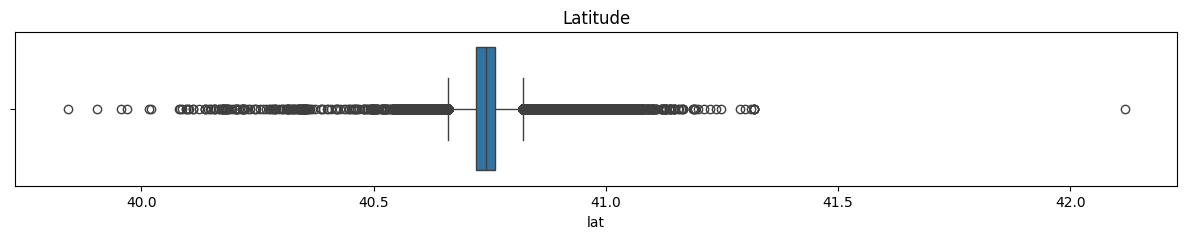

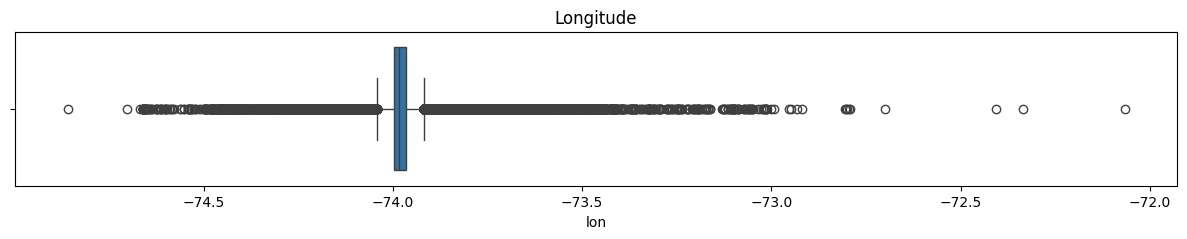

In [51]:
sample_raw_data_df = raw_data_df.sample(500000)
fig, ax = plt.subplots(figsize=(15, 2))

sns.boxplot(sample_raw_data_df, x="lat")
ax.set_title("Latitude")
  
fig, ax = plt.subplots(figsize=(15, 2))

sns.boxplot(sample_raw_data_df, x="lon")
ax.set_title("Longitude")

In [52]:
# Pour réduire/recentrer les datas on va appliquer un filtrage des outliers aux colonnes latitude et longitude

print("Initial shape: ", raw_data_df.shape)

for col in ["lat", "lon"] :
    col_mean = raw_data_df[col].mean()
    col_std = raw_data_df[col].std()
    range_min = col_mean - 3 * col_std
    range_max = col_mean + 3 * col_std
  
    raw_data_df = raw_data_df[(raw_data_df[col] > range_min) & (raw_data_df[col] <= range_max)]
    
print("New Shape: ", raw_data_df.shape)

Initial shape:  (4534327, 14)
New Shape:  (4301626, 14)


## Exploration / Visualisation

On va tenter de comprendre les différents pattern

- courses par mois
- courses par jour de la semaine
- courses par heure
- courses par heure des jour par semaine

### Rides distributions

#### Monthly

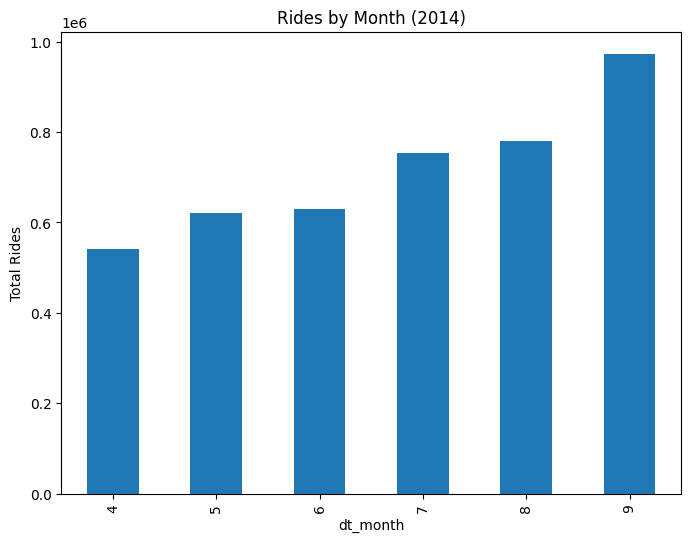

In [53]:
month_df = raw_data_df.pivot_table(index=["dt_month"],
                                  values="base",
                                  aggfunc="count")
month_df.plot(kind="bar", figsize=(8,6), legend=False)
plt.ylabel("Total Rides")
plt.title("Rides by Month (2014)")
plt.show()

#### Week days

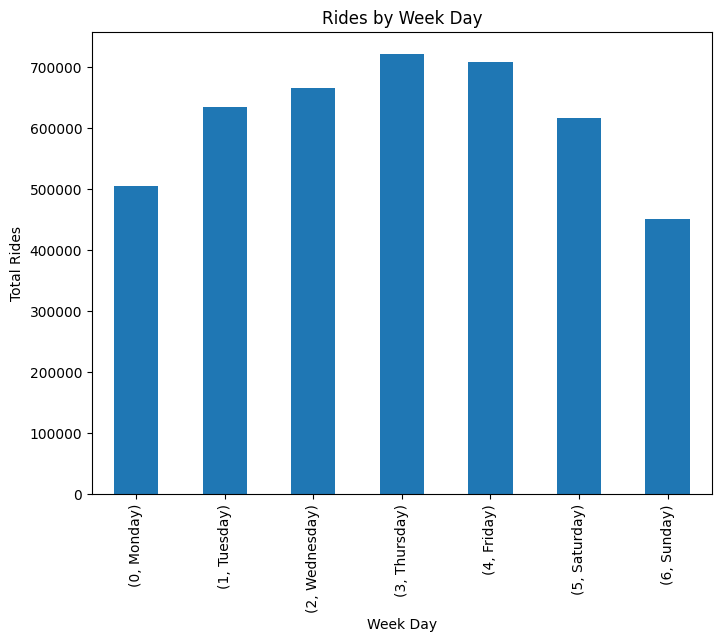

In [54]:
weekdays_df = raw_data_df.pivot_table(index=["dt_weekday", "dt_day_name"],
                                  values="base",
                                  aggfunc="count")
weekdays_df.plot(kind="bar", figsize=(8,6), legend=False)
plt.ylabel("Total Rides")
plt.xlabel("Week Day")
plt.title("Rides by Week Day")
plt.show()

#### Hourly

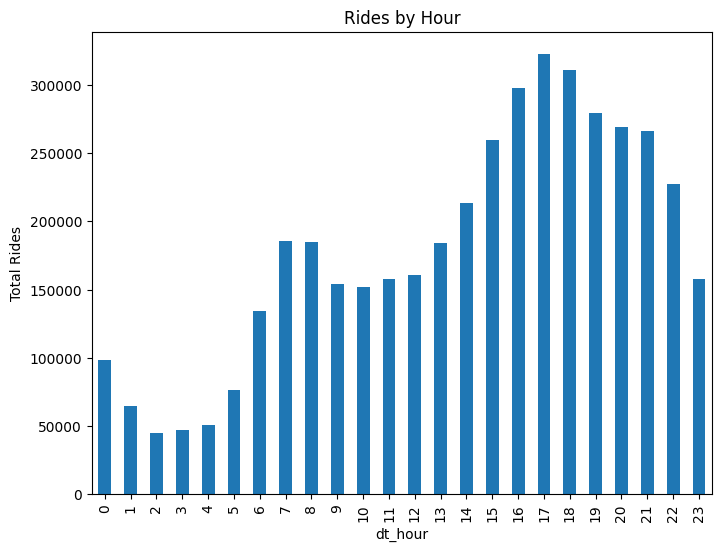

In [55]:
hour_df = raw_data_df.pivot_table(index=["dt_hour"],
                                  values="base",
                                  aggfunc="count")
hour_df.plot(kind="bar", figsize=(8,6), legend=False)
plt.ylabel("Total Rides")
plt.title("Rides by Hour")
plt.show()

#### Hourly per days of week

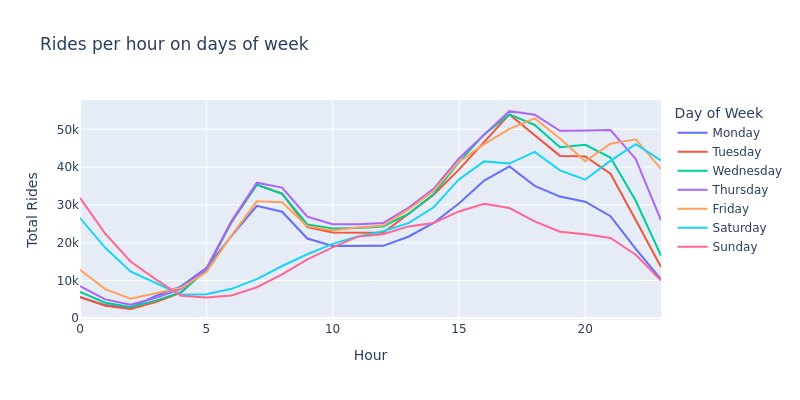

In [56]:
hour_df = raw_data_df.pivot_table(index=["dt_weekday", "dt_day_name", "dt_hour"],
                                  values="base",
                                  aggfunc="count").reset_index()

fig = px.line(hour_df,
              x="dt_hour", y="base", color="dt_day_name",
              title="Rides per hour on days of week",
              labels={
                  "dt_hour": "Hour",
                  "dt_weekday": "Day of Week",
                  "base": "Total Rides"
              },
              width=800, height=400,)

fig.update_layout(
    legend_title_text="Day of Week",
)
fig.show()

### One day rides, per hour, density map

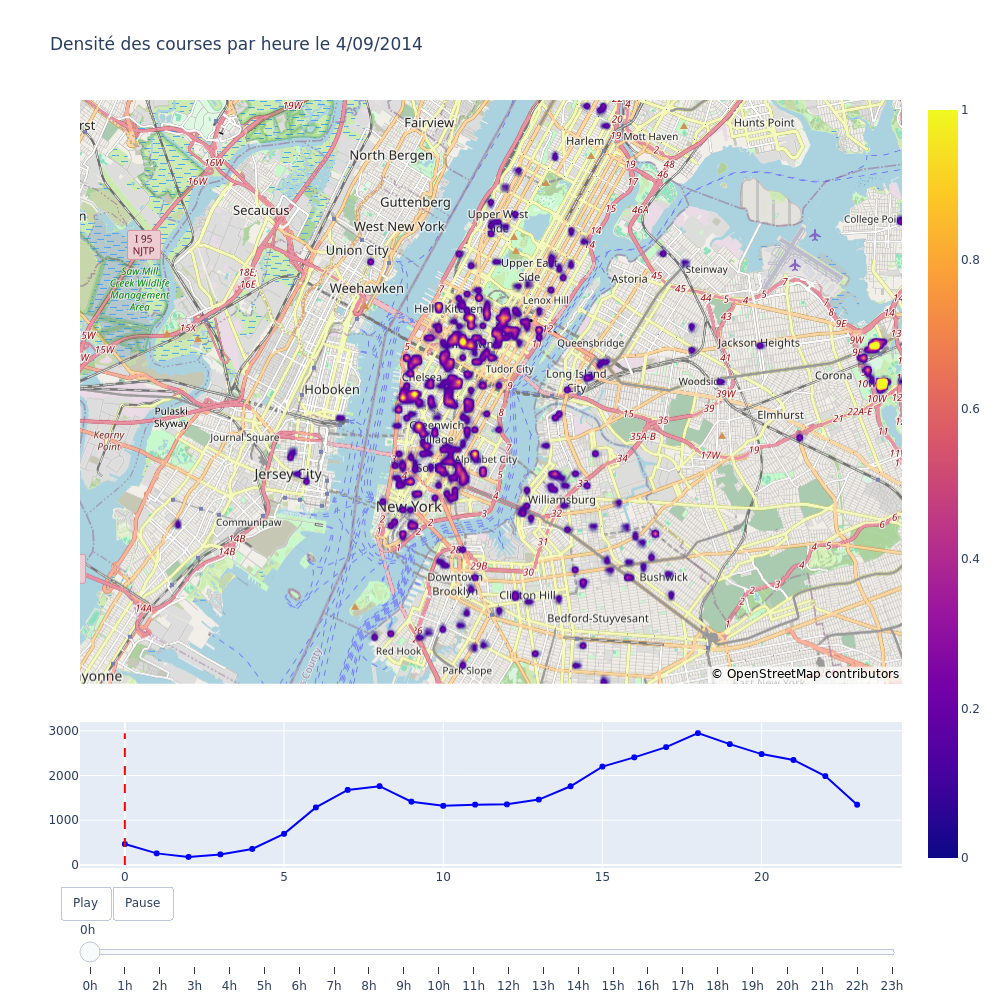

In [57]:
# Let vizualize hourly trips density on one day! We will pick a Thursday on September
# Let pick first thursday of September
month = 9 # September
weekday = 3 # Thursday
day = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_weekday"] == weekday)]["dt_day"].unique()[0]

# Keep day rides
df  = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_day"] == day)]

# Nombre de courses par heure
hourly_counts = df['dt_hour'].value_counts().sort_index()
line_chart = go.Scatter(
    x=hourly_counts.index,
    y=hourly_counts.values,
    mode='lines+markers',
    name='Nombre de courses',
    line=dict(color='blue')
)

# Base map settings
mapbox_style = "open-street-map" #"carto-positron"
mapbox_center = {"lat": df["lat"].mean(), "lon": df["lon"].mean()}

# Créer les frames pour chaque heure
frames = []
for hour in sorted(df["dt_hour"].unique()):
    hourly_df = df[df["dt_hour"] == hour]
    fig_hour = px.density_map(
        hourly_df,
        lat="lat",
        lon="lon",
        z=None,
        radius=5,
        center=mapbox_center,
        zoom=11,
        map_style=mapbox_style,
    )
    
    # Ligne verticale animée (sous forme de "shape")
    shape = {
        "type": "line",
        "xref": "x",
        "yref": "y",
        "x0": hour,
        "x1": hour,
        "y0": 0,
        "y1": hourly_counts.max(),
        "line": {"color": "red", "width": 2, "dash": "dash"}
    }

    frames.append(go.Frame(
        data=fig_hour.data,
        name=str(hour),
        layout={"shapes": [shape]}
    ))

# Figure principale
fig = go.Figure(
    data=px.density_map(
        df[df["dt_hour"] == 0],
        lat="lat",
        lon="lon",
        radius=5,
        center=mapbox_center,
        zoom=11,
        map_style=mapbox_style
    ).data,
    layout=go.Layout(
        title=f"Densité des courses par heure le {day}/{month:02d}/{df['dt_year'].unique()[0]}",
        map=dict(
            style=mapbox_style,
            center=mapbox_center,
            zoom=11
        ),
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0}, "mode": "immediate", "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": -10, "t": 18},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "pad": {"t": 50},
            "steps": [{
                "args": [[str(hour)], {"frame": {"duration": 300, "redraw": True},
                                       "mode": "immediate"}],
                "label": f"{hour}h",
                "method": "animate"
            } for hour in sorted(df['dt_hour'].unique())]
        }]
    ),
    frames=frames
)

# Ajouter la courbe en dessous dans un subplot
final_fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.8, 0.2],
    vertical_spacing=0.05,
    specs=[[{"type": "map"}], [{"type": "xy"}]]
)

# Ajouter la trace map (initiale)
for trace in fig.data:
    final_fig.add_trace(trace, row=1, col=1)

# Ajouter la courbe
final_fig.add_trace(line_chart, row=2, col=1)

fig.update_layout(
    shapes=[  # ligne initiale
        dict(
            type="line",
            x0=0,
            x1=0,
            y0=0,
            y1=hourly_counts.max(),
            line=dict(color="red", width=2, dash="dash"),
            xref="x",
            yref="y"
        )
    ]
)

# Appliquer le reste des propriétés
final_fig.update_layout(fig.layout)
final_fig.frames = fig.frames

final_fig.update_layout(height=1000, width=1000)

final_fig.show()

Avec cette carte interactive on peu facilement suivre l'évolution des courses au cours d'une journée. Notamment  les zones actives comme l'aeroport.